In [64]:
import math
import scipy.constants
import numpy as np
import matplotlib.pyplot as plt
# BLW 23-07-25

# This script has functions to simulate 1D and 2D CTFs, and create simulated through-focus series
# The CTF can be varied as a function of defocus, Cc, Cs, and kV
# The maximum spatial frequency is set as flim
# The image size for 2D CTFs is set, and the pixel size worked out from the maximum spatial frequency
# To add: functions to do LS fit to experimental CTF data

In [564]:
# define functions
# 1D CTF
def calculate_CTF( defocus, lamb, Cs, flim, fno ):
    CTF = [0 for _ in range(fno)]
    frequency = [0 for _ in range(fno)]
    frequency = [0 for _ in range(fno)]
    for i in n:
        f = float( (flim) * i/fno ) #float(flim*(i/fno))
        CTF[i] = np.sin((np.pi*defocus*lamb*(f**2)) +(0.5*np.pi*Cs*(lamb**3)*(f**4)))#Carter and Williams
        frequency[i] = f
    return CTF, frequency

# Aperture function
def aperture_function( cutoff, CTF, frequency ):
    aperture = np.zeros(len(CTF))
    n = range(0, len(aperture ))
    for i in n:
        if frequency[i] < cutoff:
            aperture[i] = 1
        if frequency[i] >= cutoff:
            aperture[i] = 0
    return aperture

def temporal_coherence( focal_spread, kV, CTF, flim, fno, Cc ):
    # in eV
    #deltaE = 1.5 #1.5 for 2100plus
    # current
    #deltaI = 1
    #I = 1
    # volts
    #deltaV = 2e-6  #2e-6 # for plus2e-6
    V = kV * 1000
    #delta = Cc * np.sqrt( 4* ((deltaI/I)**2) * ((deltaE/V)**2) * ((deltaV/V)**2) )# spatial units
    delta = Cc * (focal_spread / V)
    Et = np.zeros(len(CTF))
    n = range(0, len( Et ))
    for i in n:
        f = float(flim*(i/fno))
        Et[i] = np.exp( -0.25*(( np.pi* lamb * delta)**2) * f**4)
    return Et

def spatial_coherence( beta, defocus, CTF, lamb, Cs, flim, fno ):
    Es = np.zeros(len(CTF))
    
    dChi = np.zeros(len(CTF))
    
    n = range(0, len( Et ))
    for i in n:
        f = float(flim*(i/fno))
        # Williams and Carter
        dChi[i] = (2*np.pi*lamb*f*defocus) + (2*np.pi*Cs*(lamb**3)*(f**3))# really small numbers for some reason
        Es[i] = np.exp( -(beta / ((4*(lamb**2)))) * abs(dChi[i])**2 )
    return Es

# 2D CTF
# define variables
def plot_CTF_2d( image_size, focal_spread, lamb, flim, beta, Cs, defocus, kV, cutoff ):
    # arrays to hold 2d data
    imageX = imageY = image_size
    radius = imageX/2
    CTF2d = np.ones((imageX,imageY))
    irow, icol = np.indices(CTF2d.shape)
    centX = irow - CTF2d.shape[0] / 2.0
    centY = icol - CTF2d.shape[1] / 2.0
    #distance from centre
    iradius = (centX**2 + centY**2)**0.5
    #angle from centre
    itheta = np.arctan2(centX, centY)

    # distance per pixel
    scale = image_size / flim
    
    # scale iradius to spatial frequncy
    iradius = iradius / scale # check that distance units are set right here
    
    # 2D CTF
    CTF2d = np.sin( (np.pi*defocus*lamb*(iradius**2) ) + (0.5*np.pi*Cs*(lamb**3)*(iradius**4)) )
    
    # Aperture function
    Aperture2d = np.ones((imageX,imageY))
    n = range(0, len(Aperture2d[0] ))
    m = range(0, len(Aperture2d[1] ))
    for i in n:
        for j in m:
            if iradius[i,j] < cutoff:
                Aperture2d[i,j] = 1
            if iradius[i,j] >= cutoff:
                Aperture2d[i,j] = 0
    
    # Damping functions: check scaling
    # Temporal coherence
    delta = Cc * (focal_spread / (kV * 1000))
    Et2d = np.exp( -0.25*(( np.pi* lamb * delta)**2) * (iradius**4) )
    # Spatial coherence
    dChi_2d = (2*np.pi*lamb*iradius*defocus) + (2*np.pi*Cs*(lamb**3)*(iradius**3))# really small numbers for some reason
    Es2d = np.exp( -(beta / ((4*lamb**2))) * abs(dChi_2d)**2 )
    
    damped = ( CTF2d * Es2d * Et2d * Aperture2d )
    #CTF2d = ( CTF2d ) / np.max(CTF2d)
    #CTF2d_square = CTF2d**2
    return CTF2d, damped

# calculate relativistic wavelength from kV 
def kVToLamb(E):
    #lamb = 1.23e3/(math.sqrt(E*(1+9.78e-7*E)))
    E = E*1000
    PT = scipy.constants.h * scipy.constants.c
    PBA = (scipy.constants.e *E)*(scipy.constants.e *E)
    PBB = 2*scipy.constants.e*E*scipy.constants.m_e*(scipy.constants.c)*(scipy.constants.c)
    lamb = PT/math.sqrt(PBA+PBB)#lambda in metres
    return(lamb)

def calculate_scherzer( Csmm, lamb ):
    Cs = Csmm/1000
    scherzer = np.sqrt((4/3)*Cs*lamb)
    return scherzer

def normaliseDataRange( data ):
    return (data-np.min(data))/(np.max(data)-np.min(data))

In [693]:
# Variables
# Change these values to affect the CTF simulations
###
# Voltage in kV
kV = 200
#spherical abberation in mm
Csmm = 1.6
# chromatic in mm, 2100Plus = 1.8 mm
Ccmm = 1.8

# Defocus in nm
defocusnm = -288

# Scherzer defocus, uncomment to use
#defocusnm = calculate_scherzer(Csmm, lamb)


# maximum frequncy in nm-1
flim_nm = 5

#how many datapoints in plot for 1D CTF
fno = int(2000)

# image size in pixels for 2D CTF
image_size = 256

### putting variables into SI units, do not change below ###
n = range(0,fno)
# frequency in nm
flim = flim_nm * 1e9
# aperture cutoff in nm-1, set to flim to ignore
cutoffnm = flim # 5
# focal spread in nm, set to 0 to ignore
focal_spread = 5.25
# angle in mrad, set to 0 to ignore
beta_mrad = 0
# wavelength in m
lamb = kVToLamb(kV)
# defocus in metres, negative so underfocus
Deltz = defocusnm / 1e9
#spherical abberation in metres
Cs = Csmm / 1000
# chromatic aberration in metres
Cc = Ccmm / 1000
# scherzer defocus

# aperture function cutoff
cutoff = cutoffnm * 1e9
# angle in rad
beta = beta_mrad/1000

In [694]:
# simulate CTFs

CTF, frequency = calculate_CTF( Deltz, lamb, Cs, flim, fno )
aperture = aperture_function( cutoff, CTF, frequency )
Et = temporal_coherence( focal_spread, kV, CTF, flim, fno, Cc )
Es = spatial_coherence( beta, Deltz, CTF, lamb, Cs, flim, fno )

dampedCTF = CTF * aperture * Es * Et
squareCTF = np.square( dampedCTF )

CTF2d, damped = plot_CTF_2d( image_size, focal_spread, lamb, flim, beta, Cs, Deltz, kV, cutoff )

squared = damped * damped

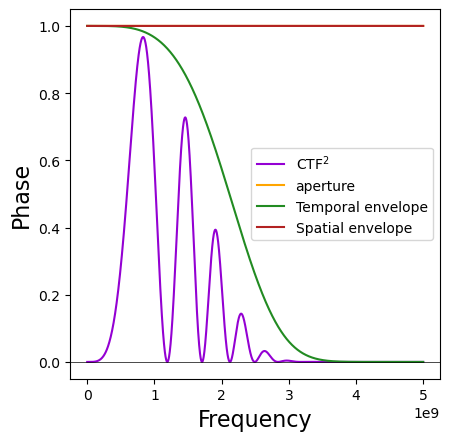

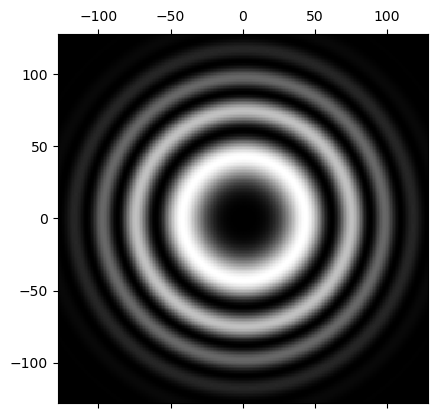

In [695]:
# plot CTFs

# create figure
fig, ax1  = plt.subplots(1,1)
fig.figaspect=[1,2]

# 1D CTFs
# plot damped CTF squared
ax1.plot(frequency, squareCTF, label='CTF$^2$', color='darkviolet')
# plot aperture function
ax1.plot(frequency, aperture, label='aperture', color='orange')
# plot temporal envelope
ax1.plot(frequency, Et, label='Temporal envelope', color='forestgreen')
# plot spatial envelope
ax1.plot(frequency, Es, label='Spatial envelope', color='firebrick')
# axis settings
ax1.legend()
ax1.set_ylabel('Phase', fontsize = 16)
ax1.set_xlabel('Frequency', fontsize = 16)
ax1.set_box_aspect(1)
ax1.axhline(0, color='black', linewidth=0.5)

# plot 2D CTF
fig, ax2  = plt.subplots(1,1)
ax2.matshow( squared,  cmap='grey', extent=[-CTF2d.shape[1]/2., CTF2d.shape[1]/2., -CTF2d.shape[0]/2., CTF2d.shape[0]/2. ] )

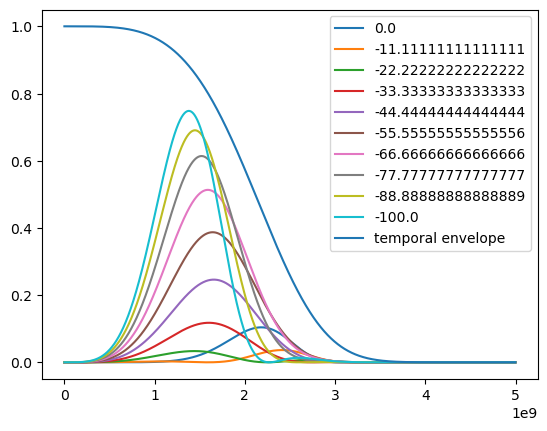

In [6]:
# This section simulates a 1D through-focus series
# simulate through-focus series
# defocus step in nm

# set the start, end, and step between defocus 
defocus_start = 0
defocus_end = -100
defocus_step = 10

defocus_range = np.linspace( defocus_start , defocus_end, defocus_step  )

through_focus_series = np.zeros([len(defocus_range), fno])

# calculate and return square of damped CTF
for i in range(0, len(defocus_range) ):
    CTF, frequency = calculate_CTF( defocus_range[i]/ 1e9, lamb, Cs, flim, fno )
    aperture = aperture_function( cutoff, CTF, frequency )
    Et = temporal_coherence( focal_spread, kV, CTF, flim, fno, Cc )
    Es = spatial_coherence( beta, defocus_range[i]/ 1e9, CTF, lamb, Cs, flim, fno )
    dampedCTF = (CTF * aperture * Es * Et)**2
    through_focus_series[i] = np.array(dampedCTF)

# plot the through-focus series and the temporal envelope
for i in range(0, len(defocus_range) ):
    plt.plot(frequency, through_focus_series[i], label = str(defocus_range[i]) )
plt.plot(frequency, Et, label='temporal envelope')
plt.legend()

#plt.plot(through_focus_series)
#polynomials = np.array([piston, tiltx, tilty, astig, astig45, defocus, comax, comay, spherical])

In [7]:
# simulate through-focus series 2D
# defocus step in nm
# BE CAREFUL or you will save an insane number of images
# saves to current working directory
# have to set the scale manually when you open in DM

import cv2

defocus_start = 200
defocus_end = -200
defocus_step = 20

defocus_range = np.linspace( defocus_start , defocus_end, defocus_step  )

through_focus_series_2d = np.zeros([image_size, image_size, len(defocus_range) ])

for i in range(0, len(defocus_range) ):
    CTF2d, damped = plot_CTF_2d( image_size, focal_spread, lamb, flim, beta, Cs, defocus_range[i]/ 1e9, kV, cutoff )
    through_focus_series_2d[:,:,i] = damped**2

through_focus_series_2d = np.float32(through_focus_series_2d)

for i in range(0, len(defocus_range) ):
    #plt.matshow( through_focus_series_2d[:, :, i], cmap='grey', extent=[-CTF2d.shape[1]/2., CTF2d.shape[1]/2., -CTF2d.shape[0]/2., CTF2d.shape[0]/2. ] )
    filename = str(i) + ".tiff"
    # save each slice as an image
    #cv2.imwrite( filename, through_focus_series_2d[:,:,i] )

Defocus (nm) = -199.83538198476268 +/- 5.708216780403384e-10
Cs (mm) = 1.3965458685274887 +/- 5.801529471916312e-11
delta = 6.676659063754964e-08 +/- 5.299286684905594e-19


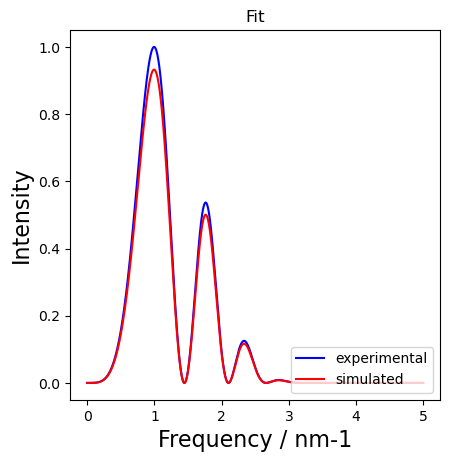

In [577]:
# fitting CTF to experimental CTF 1D
# can estimate Cs and defocus, uses an undamped CTF for the fit

#from numpy import genfromtxt
from scipy.optimize import curve_fit

# import the CTF as a np array
#data = genfromtxt('data.csv', delimiter=',')
#print(data)

# or, generate a CTF as test data

# define fitting functions as CTF functions
def fitFunc( freq, defocus, Cs, delta ):
    lamb = 2.51e-12
    #Cs = 1.4/1000
    Et = np.exp( -0.25*(( np.pi* lamb * delta)**2) * freq**4)
    func = Et*np.sin((np.pi*defocus*lamb*(freq**2)) +(0.5*np.pi*Cs*(lamb**3)*(freq**4)))**2
    return func

# do scipy LS curve fit fit
xdata = np.array(frequency)#np.linspace( 0, len(CTF), len(CTF) )  #np.array(frequency)
ydata = np.array(squareCTF)

# bounds on fit, lower then upper
defocus_bounds = (-2.5e-7, -1e-7)
Cs_bounds = (1.0e-3, 3.0e-3)
data_bounds=(0, 150 )# 0, 100
delta_bounds = (0.5e-7, 5e-7)
# convert frequency from nm-1 to m-1
initial_bounds = ([ defocus_bounds[0], Cs_bounds[0], delta_bounds[0] ],[ defocus_bounds[1], Cs_bounds[1], delta_bounds[1] ])

# do scipy LS curve fit fit
fitParams, fitCovariances = curve_fit(fitFunc, xdata, ydata, bounds=initial_bounds, method='trf')

# create figure
fig, ax1  = plt.subplots(1,1)

ax1.plot(xdata*1e-9, ( (ydata-np.min(ydata))/(np.max(ydata)-np.min(ydata)) ), color='blue', label='experimental')
ax1.plot(xdata*1e-9, fitFunc(xdata, *fitParams), color='red', label='simulated')

ax1.set_box_aspect(1)
ax1.set_title("Fit")
ax1.legend(loc='lower right')
plt.ylabel('Intensity', fontsize = 16)
plt.xlabel('Frequency / nm-1', fontsize = 16)
#ax1.set_ylim(0, 1)
#ax1.set_xlim(0, 2e9)

sigma = [np.sqrt(fitCovariances[0,0]), np.sqrt(fitCovariances[1,1]), np.sqrt(fitCovariances[2,2]) ]

print("Defocus (nm) = " +  str(fitParams[0]*1e9) + " +/- " + str(sigma[0]*1e9) )
print("Cs (mm) = " +  str(fitParams[1]*1e3) + " +/- " + str(sigma[1]*1e3))
print("delta = " +  str(fitParams[2]) + " +/- " + str(sigma[2]))

Defocus (nm) = -299.9994848469981 +/- 59.91479634450792
Cs (mm) = 1.9999996296886255 +/- 18.278593628255827
delta = 3.003230594327445e-07 +/- 3.7443201068124585e-08


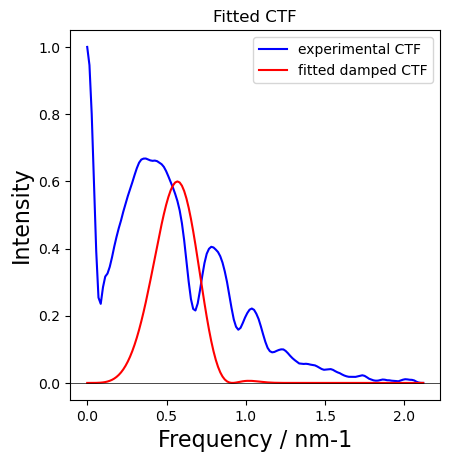

In [665]:
# 1D experimental CTF data fitting
from numpy import genfromtxt
data = genfromtxt('plus_CTFs\\80kv_plus_CTF.msa', delimiter=',')
#data = genfromtxt('plus_CTFs\\200kV_22770_CTF.csv', delimiter=',')

#from numpy import genfromtxt
from scipy.optimize import curve_fit

# define fitting functions as CTF functions
def fitCTF( freq, defocus, Cs, delta ):
    # wavelength in metres
    #lamb = 5.12e-12 #200 kV
    lamb = 4.18e-12 #80 kV
    #lamb = e-12 #60 kV
    #lamb = e-12 #40 kV
    #lamb = #20 kV
    Et = np.exp( -0.25*(( np.pi* lamb * delta)**2) * freq**4)
    func = Et*np.sin((np.pi*defocus*lamb*(freq**2)) +(0.5*np.pi*Cs*(lamb**3)*(freq**4)))**2
    return func

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(0, 150)
# bounds on defocus in metres
defocus_bounds = (-3e-7, -0.1e-7)
# bounds on spherical aberration in metres
Cs_bounds = (1e-3, 2.0e-3)
# bounds on damping function
delta_bounds = (0.1e-7, 10e-7)

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]
initial_bounds = ([ defocus_bounds[0], Cs_bounds[0], delta_bounds[0] ],[ defocus_bounds[1], Cs_bounds[1], delta_bounds[1] ])

# normalise CTF in range 0 to 1
ydata = normaliseDataRange( ydata )

# do scipy LS curve fit fit
fitParams, fitCovariances = curve_fit(fitCTF, xdata, ydata, bounds=initial_bounds, method='trf')
sigma = [np.sqrt(fitCovariances[0,0]), np.sqrt(fitCovariances[1,1]), np.sqrt(fitCovariances[2,2]) ]

# simulate 2D CTF using fitted params
#CTF2d, damped = plot_CTF_2d( image_size, focal_spread, lamb, flim, beta, Cs, Deltz, kV, cutoff )

# create figure
fig, ax1  = plt.subplots(1,1)

ax1.plot(xdata*1e-9, ( ydata ), color='blue', label='experimental CTF')
ax1.plot(xdata*1e-9, fitCTF(xdata, *fitParams), color='red', label='fitted damped CTF')
#ax1.plot(xdata*1e-9, fitCTF(xdata, fitParams[0],fitParams[1],0), color='purple', label='fitted CTF')

#ax1.plot(xdata*1e-9, fitCTF(xdata, fitParams[0],fitParams[1],0), color='green', label='fitted CTF')
#ax1.plot(xdata*1e-9, fitCTF(xdata, fitParams[0] - sigma[0],fitParams[1]-sigma[0],0), color='orange', label='lower', ls='--')
#ax1.plot(xdata*1e-9, fitCTF(xdata, fitParams[0] + sigma[0],fitParams[1]+sigma[0],0), color='red', label='upper', ls='--')

ax1.set_box_aspect(1)
ax1.set_title("Fitted CTF")
ax1.legend(loc='upper right')
ax1.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Intensity', fontsize = 16)
plt.xlabel('Frequency / nm-1', fontsize = 16)

print("Defocus (nm) = " +  str(fitParams[0]*1e9) + " +/- " + str(sigma[0]*1e9) )
print("Cs (mm) = " +  str(fitParams[1]*1e3) + " +/- " + str(sigma[1]*1e3))
print("delta = " +  str(fitParams[2]) + " +/- " + str(sigma[2]))

Defocus (nm) = -288.79679699120993 +/- 0.6454628154599297
Cs (mm) = 1.5589403220497235 +/- 0.005007085789963783


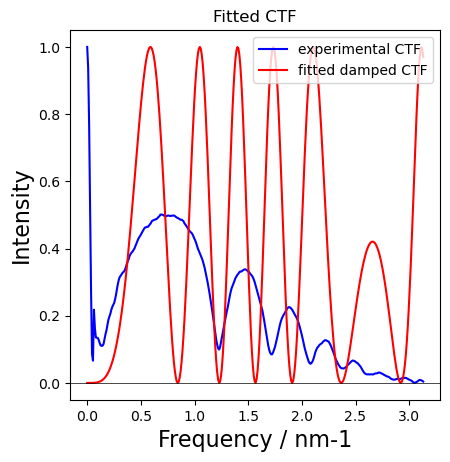

In [712]:
# 1D experimental CTF data fitting no envelope function
from numpy import genfromtxt
#data = genfromtxt('plus_CTFs\\80kv_plus_CTF.csv', delimiter=',')
data = genfromtxt('plus_CTFs\\200kV_22770_CTF.csv', delimiter=',')

#from numpy import genfromtxt
from scipy.optimize import curve_fit

# define fitting functions as CTF functions
def fitCTF( freq, defocus, Cs ):
    # wavelength in metres
    lamb = 5.12e-12 #200 kV
    #lamb = 4.18e-12 #80 kV
    #lamb = e-12 #60 kV
    #lamb = e-12 #40 kV
    #lamb = #20 kV
    func = np.sin((np.pi*defocus*lamb*(freq**2)) +(0.5*np.pi*Cs*(lamb**3)*(freq**4)))**2
    return func

# fitting bounds, lower then upper
# range of data to fit
data_bounds=(0, 350) #0, 150
# bounds on defocus in metres
defocus_bounds = (-3.0e-7, -2.8e-7)# 10e-7, 0.1e-7
# bounds on spherical aberration in metres
Cs_bounds = (1.0e-3, 2.0e-3)#1.2,2.0

# define data for fitting and convert frequency from nm-1 to m-1
xdata = data[data_bounds[0]:data_bounds[1],0]*1e9
ydata = data[data_bounds[0]:data_bounds[1],1]
initial_bounds = ([ defocus_bounds[0], Cs_bounds[0] ],[ defocus_bounds[1], Cs_bounds[1] ])

# normalise CTF in range 0 to 1
ydata = normaliseDataRange( ydata )

# do scipy LS curve fit fit
fitParams, fitCovariances = curve_fit(fitCTF, xdata, ydata, bounds=initial_bounds, method='trf')
sigma = [np.sqrt(fitCovariances[0,0]), np.sqrt(fitCovariances[1,1])  ]

# create figure
fig, ax1  = plt.subplots(1,1)

ax1.plot(xdata*1e-9, ( ydata ), color='blue', label='experimental CTF')
ax1.plot(xdata*1e-9, fitCTF(xdata, *fitParams), color='red', label='fitted damped CTF')

ax1.set_box_aspect(1)
ax1.set_title("Fitted CTF")
ax1.legend(loc='upper right')
ax1.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Intensity', fontsize = 16)
plt.xlabel('Frequency / nm-1', fontsize = 16)

print("Defocus (nm) = " +  str(fitParams[0]*1e9) + " +/- " + str(sigma[0]*1e9) )
print("Cs (mm) = " +  str(fitParams[1]*1e3) + " +/- " + str(sigma[1]*1e3))